**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [53]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [54]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [55]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [56]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [57]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [58]:
set_rf_samples(50000)

In [59]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20588707837103373, 0.24879715901914667, 0.9114083056661133, 0.8894550754051862, 0.8943103980303482]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [60]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.45 s, sys: 38.6 ms, total: 1.49 s
Wall time: 1.57 s


(9.290720818312652, 0.28262383849962963)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [61]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 90.8 ms, sys: 76.3 ms, total: 167 ms
Wall time: 1.02 s


(9.290720818312652, 0.28262383849962963)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

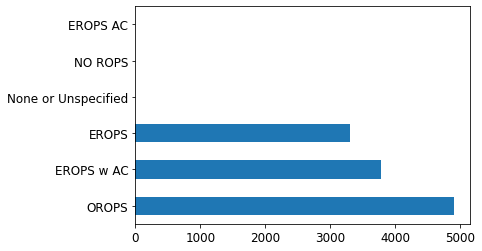

In [62]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [63]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.843216,0.276700
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576610,0.265136
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683547,0.223317


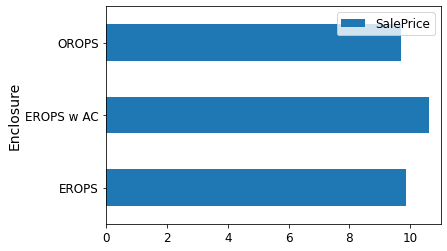

In [64]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

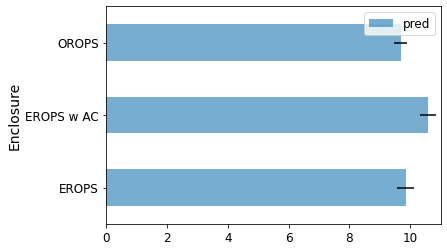

In [65]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

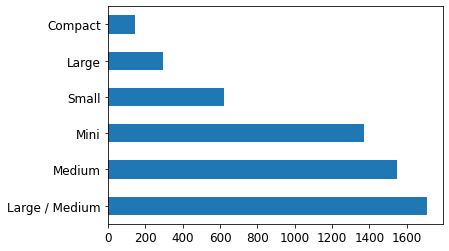

In [66]:
raw_valid.ProductSize.value_counts().plot.barh();

In [67]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.873820,0.349746
Large,10.470589,10.378775,0.349515
Large / Medium,10.691871,10.650266,0.296538
Medium,10.681511,10.623205,0.288018
Mini,9.535147,9.565131,0.247415
Small,10.324448,10.322765,0.307958


In [68]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035422
Large             0.033676
Small             0.029833
Large / Medium    0.027843
Medium            0.027112
Mini              0.025866
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [69]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.168701
13,ProductSize,0.107167
37,Coupler_System,0.102312
14,fiProductClassDesc,0.085294
10,fiSecondaryDesc,0.052747
63,saleElapsed,0.050310
39,Hydraulics_Flow,0.049750
2,ModelID,0.047376
19,Enclosure,0.038851
8,fiModelDesc,0.032105


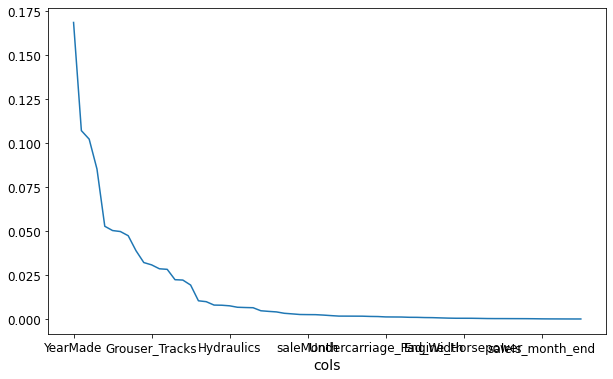

In [70]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [71]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

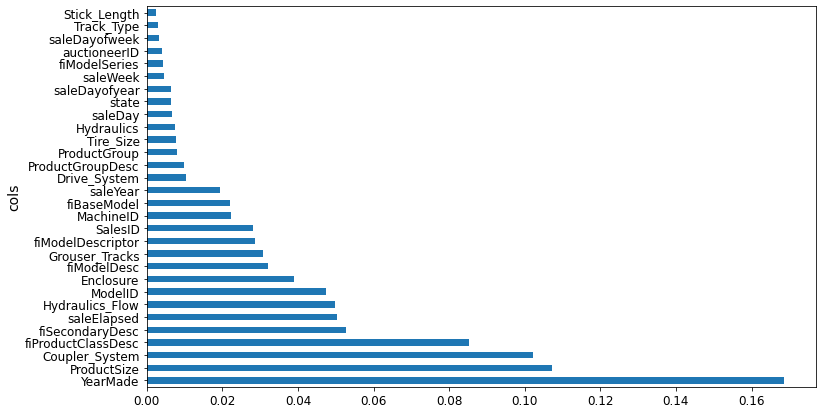

In [72]:
plot_fi(fi[:30]);

In [73]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [74]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [75]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2071333121331877, 0.24628914518452083, 0.9103325693465044, 0.8916725508236075, 0.893877757598412]


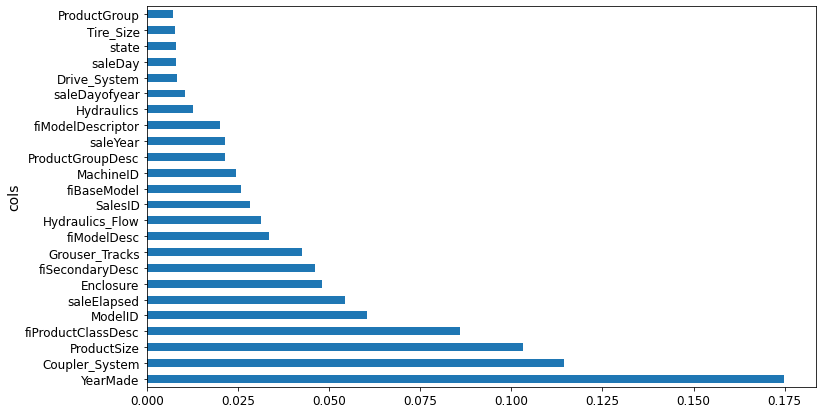

In [76]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [77]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2078380833451453, 0.2549516027978379, 0.9097213442984909, 0.8839183781841989, 0.8919000887375472]


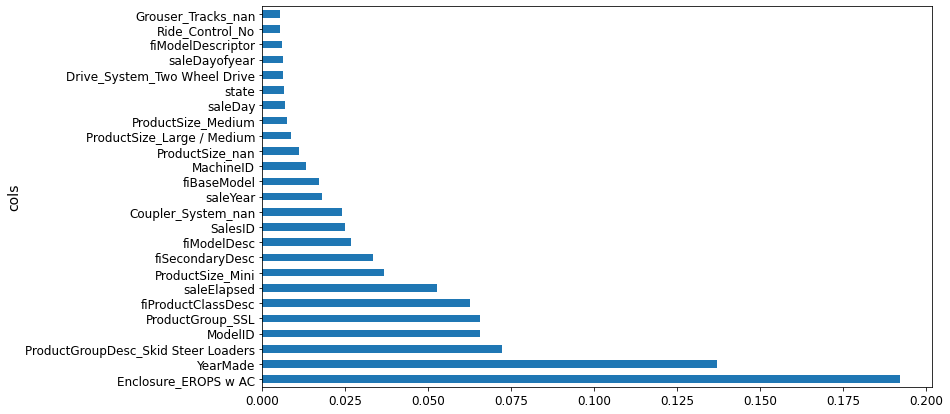

In [78]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [79]:
from scipy.cluster import hierarchy as hc

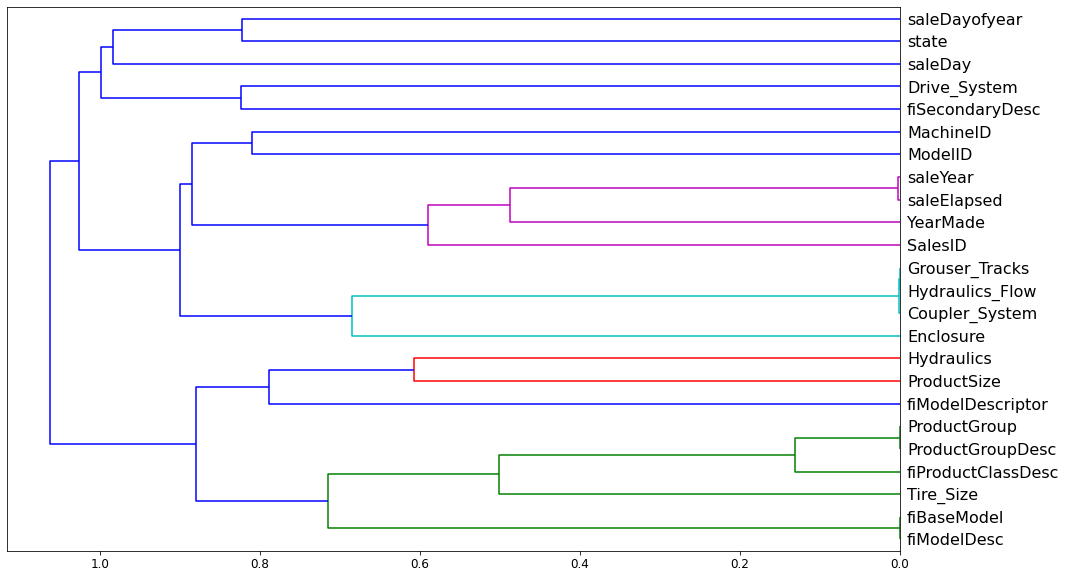

In [80]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [81]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [82]:
get_oob(df_keep)

0.8898549896642369

Now we try removing each variable one at a time.

In [83]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8893394410076747
saleElapsed 0.8868361984512428
fiModelDesc 0.8886602468096987
fiBaseModel 0.8895750848645162
Grouser_Tracks 0.8907267363013697
Coupler_System 0.8900340712714065


It looks like we can try one from each group for removal. Let's see what that does.

In [84]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8887441384617195

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [85]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [86]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [87]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [88]:
reset_rf_samples()

In [89]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1259332193104087, 0.22883533254718164, 0.9668551973588603, 0.906482231308072, 0.9082679526131433]


# Partial dependence

In [91]:
from pdpbox import pdp
from plotnine import *

In [92]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [93]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

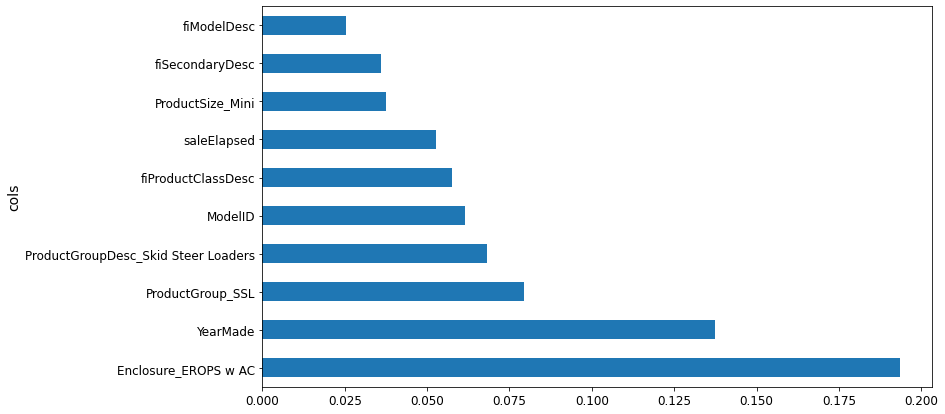

In [94]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

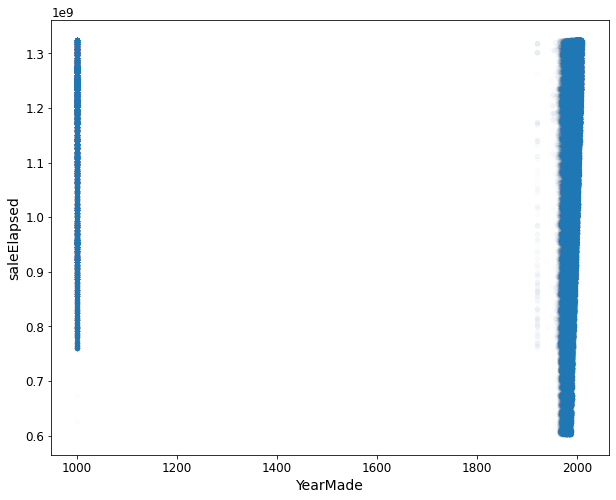

In [95]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [96]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

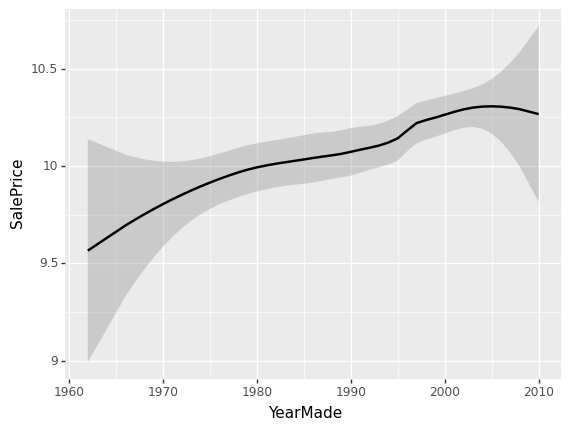

<ggplot: (336072175)>

In [101]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [102]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [105]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x143d38b38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x143d45208>})

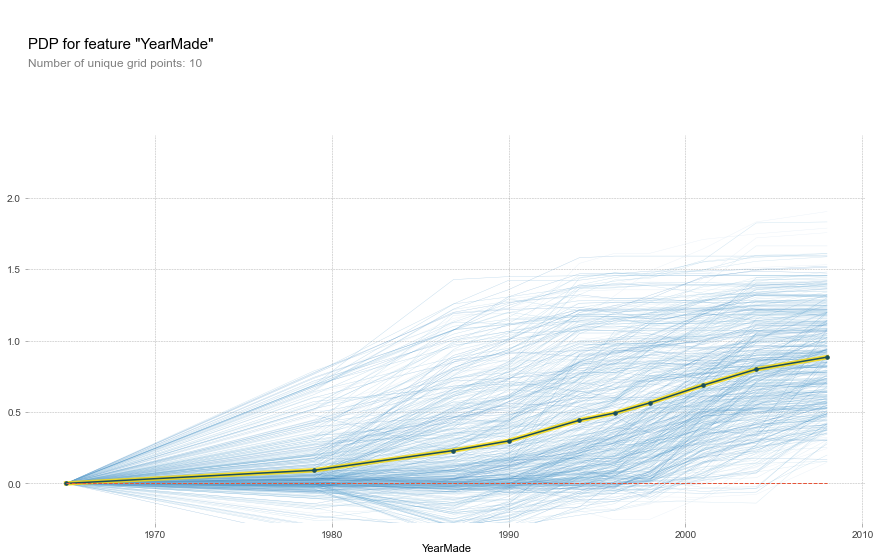

In [106]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x140ee67b8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x144a74fd0>})

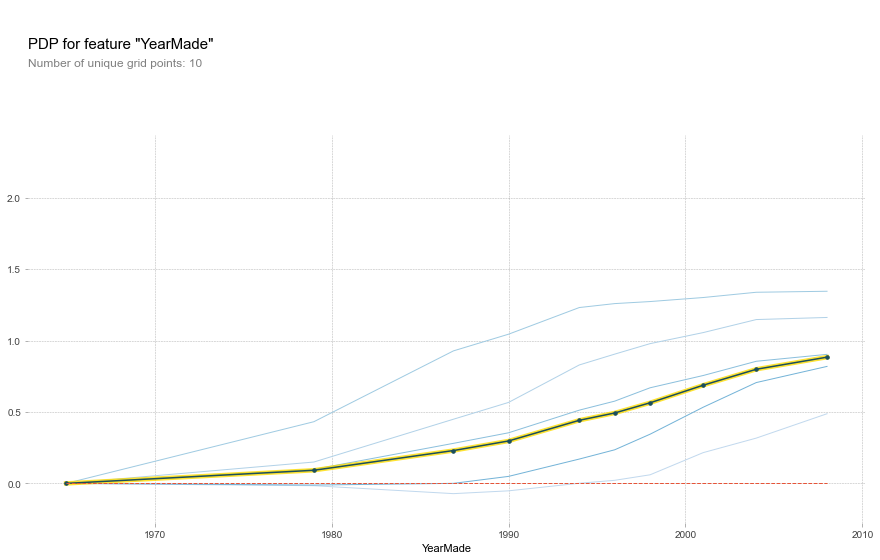

In [107]:
plot_pdp('YearMade', clusters=5)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x143c10748>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x143c29780>})

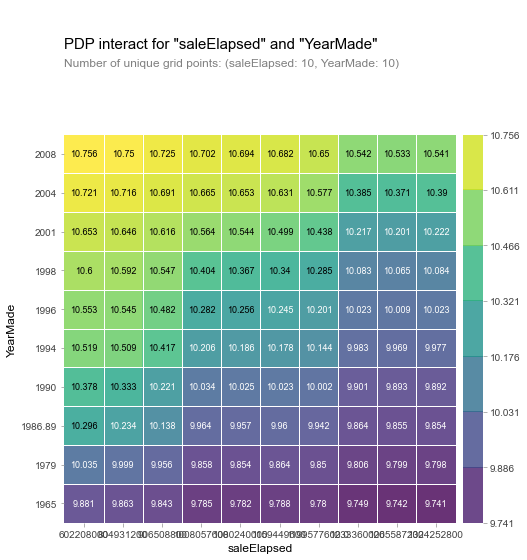

In [111]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, features=feats, model_features=x.columns)
pdp.pdp_interact_plot(p, feats,plot_type='grid')

In [112]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

ValueError: feature does not exist: Enclosure

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

In [ ]:
contributions[0].sum()

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

In [ ]:
(X_valid[feats]/1000).describe()

In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [113]:
plot_fi(rf_feat_importance(m, X_train));

Error in callback <function flush_figures at 0x11eb0ba60> (for post_execute):


KeyboardInterrupt: 

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)